# ApRES dat files --> zarr in a google bucket

This notebook uses xapres to load each dat file in a given directory and writes it to an individual zarr store in the ldeo-glaciology google bucket. It then writes lazily loads all the zarrs, concatenates them, and writes them to a single zarr store.

In [1]:
import numpy as np
import os
import gcsfs
import fsspec
import json
import xarray as xr
import sys
sys.path.append("/home/jovyan/XApRES/src/XApRES/")
import ApRESDefs
import zarr
from tqdm.notebook import trange, tqdm

## A101
There are three instruments in this datast, A101, A103, and A104. 

We start with A101.

### Get a list of the .DAT files in the A101 directory.

In [2]:
xa = ApRESDefs.xapres(max_range=1400)
dat_file_list = xa.list_files(directory='gs://ldeo-glaciology/GL_apres_2022/A101', 
            remote_load = True)

Load a token which enables us to write to the bucket.

In [3]:
with open('../../secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)

Loop over the .DAT files in `dat_file_list` and loadthe data into an xarray using `ApRESDefs.xapres.load_all`

In [5]:
#dat_file_list  = dat_file_list[0:2]
directory='gs://ldeo-glaciology/GL_apres_2022/A101'

for file in tqdm(dat_file_list): 
    xa = ApRESDefs.xapres(max_range=1400)
    xa.load_all(directory, 
            remote_load = True,
            file_names_to_process=[file])
    filename = f'gs://ldeo-glaciology/GL_apres_2022_individual_zarrs_all_4/dat_{file}' 
    mapper = fsspec.get_mapper(filename, mode='w', token=token)
    
    ds = xa.data
    ds.attrs = []
    ds.to_zarr(mapper, consolidated=False)

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
dat_file_list[0:2]

['ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1530/DATA2022-05-26-1530.DAT']

Start a cluster (first use the menu on the left to create this cell).

In [4]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35679")
client

<Client: 'tcp://127.0.0.1:35679' processes=13 threads=52, memory=191.34 GiB>

Load and concatenate all the A101 zarr files. 

In [5]:
ds_all = xr.open_mfdataset("gs://ldeo-glaciology/GL_apres_2022_individual_zarrs_all_4/dat*",
                           chunks = {}, 
                           engine = 'zarr', 
                           consolidated = False, 
                           parallel = True)
ds_all

<xarray.Dataset>
Dimensions:          (time: 11723, attenuator_setting_pair: 2,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(13, 2), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(13, 2), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(13,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(13,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(4, 5001, 5, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(4, 1665, 5, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>

In [6]:
ds_all.profile

<xarray.DataArray 'profile' (time: 11723, profile_range: 6658, chirp_num: 20,
                             attenuator_setting_pair: 2)>
dask.array<concatenate, shape=(11723, 6658, 20, 2), dtype=complex128, chunksize=(12, 1665, 5, 1), chunktype=numpy.ndarray>
Coordinates:
    AFGain         (time, attenuator_setting_pair) int64 dask.array<chunksize=(13, 2), meta=np.ndarray>
    attenuator     (time, attenuator_setting_pair) float64 dask.array<chunksize=(13, 2), meta=np.ndarray>
    burst_number   (time) int64 dask.array<chunksize=(13,), meta=np.ndarray>
  * chirp_num      (chirp_num) int64 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
    filename       (time) <U83 dask.array<chunksize=(13,), meta=np.ndarray>
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25T1...
Dimensions without coordinates: attenuator_setting_pair
Attributes:
    description:  complex profile computed from the fourier transform of the ...
    long_name:    profile
    units:        -

Check how large the dataset is

In [13]:
ds_all.nbytes/1e9

200.016558212

Check the first and last filename. 

They file should be (from looking at the google bucket directly):
- DATA2022-05-22-1939.DAT 
- DATA2022-09-24-2120.DAT
 

In [14]:
ds_all.time.shape[0]

11723

In [18]:
print(f"first file name in dataset: {ds_all.filename[0].values}")
print(f"last file name in dataset: {ds_all.filename[-1].values}")

first file name in dataset: ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT
last file name in dataset: ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-09-22-2220/DATA2022-09-24-2120.DAT


Check that there are roughly the correct number of time slices.

In [37]:
fs = gcsfs.GCSFileSystem()
A101_dats_in_bucket = fs.glob(directory + '/**/*.DAT', recursive = True)
number_of_A101_dats_in_bucket = len(A101_dats_in_bucket)
dat = xa.load_dat_file(A101_dats_in_bucket[30], remote_load= True)
number_of_bursts_dat_approx = dat.NoBurstsInFile

approx_number_of_times = number_of_bursts_dat_approx * number_of_A101_dats_in_bucket
print(f"The number of time slices should be approximately {approx_number_of_times}")
print(f"In fact it is {ds_all.time.shape[0]}")

The number of time slices should be approximately 11938
In fact it is 11723


Check that the time slices are all in order. First by plotting the values.

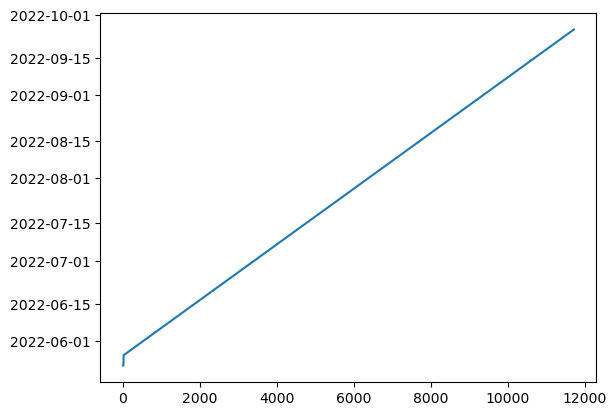

In [15]:
import matplotlib.pyplot as plt
plt.plot(ds_all.time.values)

Check that the time dimension is increasing by taking the diff. We see that the minimum diff value is postive, so `time` must be increasing. 

In [6]:
assert ds_all.time.diff(dim='time').min() > 0 

Check that all the dat files are in the dataset

In [7]:
# take the filenames from the dataset
unique_filenames = np.unique(ds_all.filename.values) 
# and ccheck that they are the same as the files loaded by xapres in the call at the top of this NB
assert all(unique_filenames == dat_file_list)

## Rechunk a small version of the DS as a test

We would like our key variables `chirp` and `profiles` to be in chinks of 100-200 MB. 

- Probably need to be 20 in the `chirp_num` dimension. 
- can be 1 in the `attenuator setting pair` dimension.
- they should be 40001 and 6658, respectively, in the `chirp_time` and `profile_range` dimensions

In [16]:
ds_small = ds_all.isel(time=[0, 3])
for var in ds_small:
    del ds_small[var].encoding['chunks']
ds_small

<xarray.Dataset>
Dimensions:          (time: 2, attenuator_setting_pair: 2, chirp_time: 40001,
                      chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(2,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 2022-05-22T20:...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(2, 5001, 5, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(2, 1665, 5, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>

For this small version we can use time chunk = 1.

In [17]:
ds_small_rechunked = ds_small.chunk({'time' : 1, 'chirp_num' : 20, 'attenuator_setting_pair': 1, 'chirp_time': 40001, 'profile_range': 6658})
ds_small_rechunked.persist()

<xarray.Dataset>
Dimensions:          (time: 2, attenuator_setting_pair: 2, chirp_time: 40001,
                      chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 2022-05-22T20:...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(1, 40001, 20, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(1, 6658, 20, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

## Write this small test DS to a single zarr

In [94]:
filename = 'gs://ldeo-glaciology/GL_apres_2022/A101_all_4' 
mapper = fsspec.get_mapper(filename, mode='w', token=token)
    

ds_small_rechunked.to_zarr(mapper, consolidated=True, safe_chunks=False)

In [95]:
ds_small_rechunked_reloaded = xr.open_dataset(filename, engine='zarr', consolidated=True, chunks={}) 
ds_small_rechunked_reloaded

<xarray.Dataset>
Dimensions:          (time: 2, attenuator_setting_pair: 2, chirp_time: 40001,
                      chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(2,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 2022-05-22T20:...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(1, 40001, 20, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(1, 6658, 20, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

# Now do the rechunk and the zarr-write for the full dataset

In [6]:
for var in ds_all:
    del ds_all[var].encoding['chunks']


In [7]:
ds_all_rechunked = ds_all.chunk({'time' : 50, 'chirp_num' : 20, 'attenuator_setting_pair': 1, 'chirp_time': 40001, 'profile_range': 6658})
ds_all_rechunked

<xarray.Dataset>
Dimensions:          (time: 11723, attenuator_setting_pair: 2,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(50, 1), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(50, 1), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(50,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(50,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(50, 40001, 20, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(50, 6658, 20, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>

## Write to zarr
This seems to crash the kernel

In [ ]:
filename = 'gs://ldeo-glaciology/GL_apres_2022/A101_all_6' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 

ds_all_rechunked.to_zarr(mapper, consolidated=True, safe_chunks=False)

## Reload the result to check that it all made it

In [8]:
filename = 'gs://ldeo-glaciology/GL_apres_2022/A101_all_6' 

ds_all_rechunked_reloaded = xr.open_dataset(filename, engine='zarr', consolidated=True, chunks={}) 
ds_all_rechunked_reloaded

<xarray.Dataset>
Dimensions:          (time: 11723, attenuator_setting_pair: 2,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(50, 1), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(50, 1), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(13,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(13,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(50, 40001, 20, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(50, 6658, 20, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>

In [9]:
ds_all_rechunked_reloaded.nbytes/1e9

200.016558212

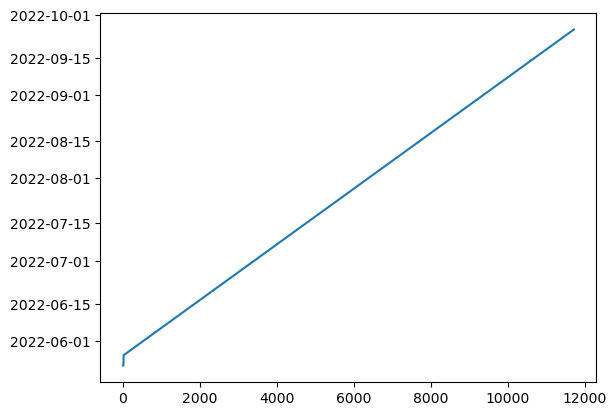

In [8]:
import matplotlib.pyplot as plt
plt.plot(ds_all_rechunked_reloaded.time.values)

In [22]:
time_step = 1

ds_all_rechunked_reloaded.profile.isel(time=time_step).identical(ds_all_rechunked.profile.isel(time=time_step))

False

In [38]:
all(ds_all_rechunked_reloaded.profile.values == ds_all_rechunked.profile.values)


KeyboardInterrupt



In [28]:
ds_all_rechunked.time

<xarray.DataArray 'time' (time: 11723)>
array(['2022-05-22T19:40:20.000000000', '2022-05-22T19:54:54.000000000',
       '2022-05-22T20:09:53.000000000', ..., '2022-09-25T13:50:49.000000000',
       '2022-09-25T14:05:43.000000000', '2022-09-25T14:20:39.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    burst_number  (time) int64 dask.array<chunksize=(50,), meta=np.ndarray>
    filename      (time) <U83 dask.array<chunksize=(50,), meta=np.ndarray>
  * time          (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25T14...
Attributes:
    long_name:  time of burst

In [17]:
ds_all_rechunked_reloaded.time.isel(time=time_step).values == ds_all_rechunked.time.isel(time=time_step).values

True

In [19]:
ds_all_rechunked_reloaded.profile.isel(time=time_step).values == ds_all_rechunked.profile.isel(time=time_step).values

array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]]])

In [20]:
ds_all_rechunked_reloaded.profile.isel(time=time_step).values

array([[[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       ...,

       [[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j],
        [0.+0.j

In [21]:
ds_all_rechunked.profile.isel(time=time_step).values

array([[[ 1.03936485e-02+0.00000000e+00j,
          1.07542094e-02+0.00000000e+00j],
        [ 1.04207300e-02+0.00000000e+00j,
          1.07526934e-02+0.00000000e+00j],
        [ 1.04212132e-02+0.00000000e+00j,
          1.07483614e-02+0.00000000e+00j],
        ...,
        [ 1.04252129e-02+0.00000000e+00j,
          1.07497086e-02+0.00000000e+00j],
        [ 1.04234598e-02+0.00000000e+00j,
          1.07479140e-02+0.00000000e+00j],
        [ 1.04258307e-02+0.00000000e+00j,
          1.07492854e-02+0.00000000e+00j]],

       [[ 1.39041981e-05+9.15838690e-03j,
          2.77998768e-06+9.47626688e-03j],
        [ 1.11867671e-05+9.18237659e-03j,
          2.59725269e-06+9.47488898e-03j],
        [ 1.02176907e-05+9.18260679e-03j,
          3.02370729e-06+9.47114977e-03j],
        ...,
        [ 1.13157011e-05+9.18623010e-03j,
          3.30876182e-06+9.47243559e-03j],
        [ 1.08503077e-05+9.18475597e-03j,
          3.45928513e-06+9.47084836e-03j],
        [ 1.08039235e-05+9.18686643e-